In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#Generate simple images of random rectangles, image size = 8x8

num_images = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes  = np.zeros((num_images, num_objects, 4))
imgs = np.zeros((num_images, img_size, img_size))  #Create images of size 8x8 and set background to white, 0 = white

for i_img in range(num_images):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size = 2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1  #Set the random rectangles in white background to black, 1 = black
        bboxes[i_img, i_object] = [x, y, w, h]

imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 1, 4))

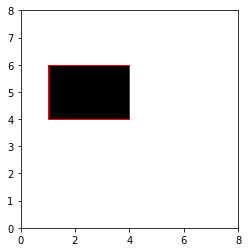

In [3]:
i = np.random.randint(0, num_images)
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [4]:
#Reshape and normalize the immages data to mean 0 and std 1
X = (imgs.reshape(num_images, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 64), -6.459721646479011e-17, 1.0)

In [5]:
#Normalize x, y, w, h by img_size, so that all values are between 0 and 1
#Important: Do not shift to negative values (e.g. by settig to mean 0), because IOU calulations needs positive w and h.
y = bboxes.reshape(num_images, -1) / img_size
y.shape, np.mean(y), np.std(y)

((50000, 4), 0.280670625, 0.17500674169045424)

In [6]:
#Split training and test images
i = int(0.8 * num_images)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [7]:
#Build the model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
model = Sequential([
                    Dense(200, input_dim = X.shape[-1]),
                    Activation('relu'),
                    Dropout(0.2),
                    Dense(y.shape[-1])
                    ])
model.compile('adadelta', 'mse')

In [9]:
#Train
model.fit(train_X, train_y, nb_epoch = 30, validation_data = (test_X, test_y), verbose = 2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 40000 samples, validate on 10000 samples
Epoch 1/30
 - 7s - loss: 0.0292 - val_loss: 6.8164e-04
Epoch 2/30
 - 6s - loss: 0.0018 - val_loss: 3.5233e-04
Epoch 3/30
 - 6s - loss: 0.0013 - val_loss: 2.1303e-04
Epoch 4/30
 - 7s - loss: 0.0011 - val_loss: 1.4007e-04
Epoch 5/30
 - 7s - loss: 0.0010 - val_loss: 1.0659e-04
Epoch 6/30
 - 5s - loss: 9.3442e-04 - val_loss: 1.1523e-04
Epoch 7/30
 - 6s - loss: 8.9246e-04 - val_loss: 1.0871e-04
Epoch 8/30
 - 6s - loss: 8.5330e-04 - val_loss: 1.1063e-04
Epoch 9/30
 - 6s - loss: 8.3455e-04 - val_loss: 9.5882e-05
Epoch 10/30
 - 6s - loss: 8.0802e-04 - val_loss: 8.5605e-05
Epoch 11/30
 - 6s - loss: 7.8741e-04 - val_loss: 8.2301e-05
Epoch 12/30
 - 7s - loss: 7.7011e-04 - val_loss: 1.0423e-04
Epoch 13/30
 - 7s - loss: 7.5428e-04 - val_loss: 9.2430e-05
Epoch 14/30
 - 7s - loss: 7.4481e-04 - val_loss: 8.5776e-05
Epoch 15/30
 - 7s - loss: 7.3306e-04 - val_loss: 6.5844e-05
Epoch 16/30
 - 7s - loss: 7.1496e-04 - val_loss: 7.5495e-05
Epoch 17/30
 - 7s -

In [10]:
#Predict bounding boxes on the test images.
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [11]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over area of union'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]
    
    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:   #No Overlap
        return 0
    I = w_I * h_I
    
    U = w1 * h1 + w2 * h2 - I

    return I / U

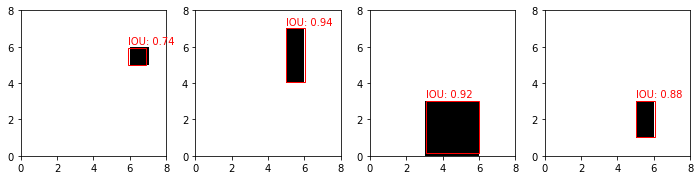

In [12]:
#Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap ='Greys', interpolation ='none', origin ='lower', extent = [0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec = 'r', fc = 'none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1] + pred_bbox[3] + 0.2), color = 'r')
        
#plt.savefig('plots/bw-single-rectangle_prediction.png', dpi=300)

In [13]:
#Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.8813179860423505